[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yusuke-kayahara/kyhr-study/blob/main/code/Learning_MCMC_through_the_Metropolis_Hastings_algorithm.ipynb)

# 前提
- 出発点: MCMCはPPLを使えばできる&仕組みもなんとなく分かるものの、細かいところは正直分かっていない
- 目的: MCMCの仕組みを理解する
  - 仕組みの理解のため、MCMCの中でも簡単なMH法(Metropolis-Hastings)を実装する
- 流れ
  - 単一iterの実装: 初期値からどのようにパラメータが更新されているか確認する
  - 複数iterの実装: 実装した1iterを複数回実行し、どのように普段のMCMCが実装されているか理解する

# データ設定
- タスク設定: 単回帰モデル(y = beta * x)の係数betaを推定する
  - 下記プロットから、bは0.5付近の値を採ることが予想される
    - OLS推定を行った結果は、beta=0.509となった

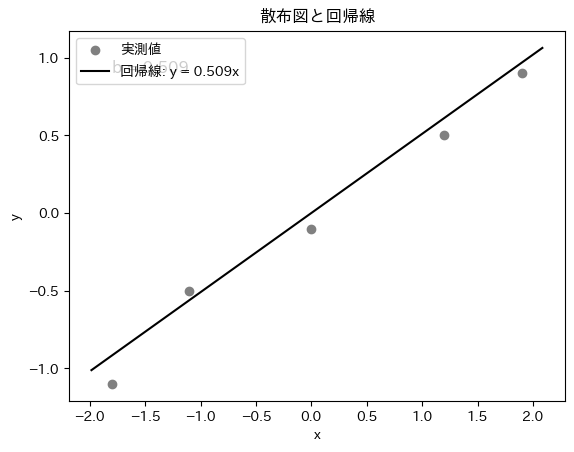

In [1]:
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

# データの準備
np.random.seed(42) # 再現性のためのシード設定
y = np.array([-1.1, -0.5, -0.1, 0.5, 0.9]) 
x = np.array([-1.8,-1.1,0,1.2,1.9]) 

# OLS推定
# b = (X'X)^-1X'Y
X = x.reshape(-1, 1)  # 形状を(n, 1)に変更
XtX_inv = np.linalg.inv(X.T @ X)
XtY = X.T @ y
b = XtX_inv @ XtY

# 散布図
plt.scatter(x, y, color='gray', label='実測値')

# 回帰線
x_vals = np.array(plt.xlim())
y_vals = b * x_vals
plt.plot(x_vals, y_vals, color='black', label=f'回帰線: y = {b[0]:.3f}x')

# bの推定値を表示
plt.text(min(x), max(y), f'b = {b[0]:.3f}', fontsize=12)

plt.xlabel('x')
plt.ylabel('y')
plt.title('散布図と回帰線')
plt.legend()

plt.show()

# 単一iterの実装
- MH法における単一iterを実装し、仕組みを理解する

### 初期値と提案値の設定
- 初期値は0~1の一様分布からランダムに選ぶ
  - 2iter以降は前のiterで採択されたパラメータを用いる
- 提案値は初期値に対して正規分布に従うノイズを加える

In [44]:
beta_current = np.random.rand() # 初期値
print(f'betaの初期値:{beta_current}')

betaの初期値:0.15452082999051897


In [45]:
# 提案分布の定義
# betaに正規分布に従うノイズを加えた値を提案値として返す
def proposal(beta):
    return beta + np.random.normal(0, 0.5) 

beta_proposed = proposal(beta_current) # 提案分布からパラメータをサンプリング
print(f'betaの提案値:{beta_proposed}')

betaの提案値:0.40155278947827877


### 尤度関数の算出
- 誤差は正規分布に従うと仮定

In [46]:
# 尤度関数の定義
# 誤差が正規分布に従うとする
def likelihood(beta, x, y):
    y_pred = beta * x
    sigma = np.std(y - y_pred)
    return np.exp(-0.5 * np.sum(((y - y_pred) / sigma) ** 2)) / (np.sqrt(2 * np.pi * sigma ** 2) ** len(y))

likelihood_current = likelihood(beta_current, x, y) # 初期値の尤度
likelihood_proposed = likelihood(beta_proposed, x, y) # 提案値の尤度
print(f'初期値の尤度:{likelihood_current:1f} \n提案値の尤度:{likelihood_proposed:1f}')

初期値の尤度:0.025955 
提案値の尤度:3.475668


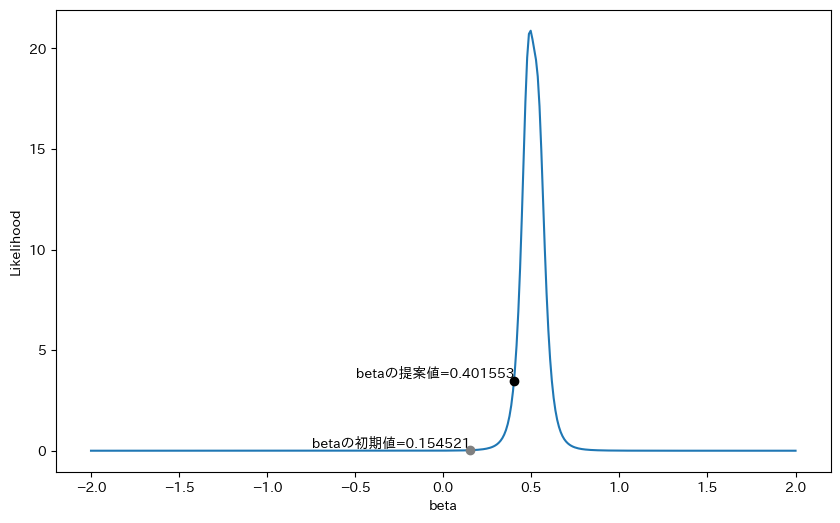

In [47]:
# betaの範囲を設定
beta_values=np.linspace(-2,2,400)

# 各betaに対する尤度の計算
likelihood_values = [likelihood(beta, x, y) for beta in beta_values]

# 尤度関数のグラフ化
plt.figure(figsize=(10, 6))
plt.plot(beta_values, likelihood_values, label='Likelihood Function')
# 初期値のプロット
plt.scatter([beta_current], [likelihood_current], color='gray', zorder=5)
plt.text(beta_current, likelihood_current, f' betaの初期値={beta_current:2f}', verticalalignment='bottom', horizontalalignment='right')
# 提案値のプロット
plt.scatter([beta_proposed], [likelihood_proposed], color='black', zorder=5)
plt.text(beta_proposed, likelihood_proposed, f' betaの提案値={beta_proposed:2f}', verticalalignment='bottom', horizontalalignment='right')

plt.xlabel('beta')
plt.ylabel('Likelihood')
plt.show()

### 事前分布の確率密度関数の算出
- 事前分布として、平均0.5, 標準偏差1の正規分布を置く

In [48]:
# 事前分布の確率密度関数の定義
# 平均0.5, 標準偏差1の正規分布を仮定する
def prior(beta, mu=0.5, sigma=1):
    return np.exp(-0.5 * ((beta - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

prior_current = prior(beta_current) # 初期値の事前分布の確率密度
prior_proposed = prior(beta_proposed) # 提案値の事前分布の確率密度
print(f'初期値の事前分布の確率密度:{prior_current:1f} \n提案値の事前分布の確率密度:{prior_proposed:1f}')

初期値の事前分布の確率密度:0.375831 
提案値の事前分布の確率密度:0.397014


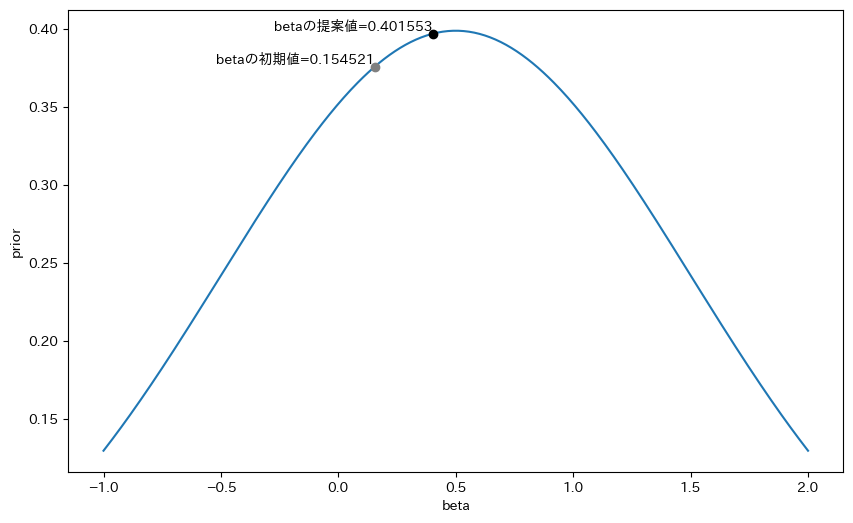

In [49]:
# betaの範囲を設定
beta_values = np.linspace(-1, 2, 400)

# 各betaに対する事前分布の確率密度の計算
prior_values = [prior(beta) for beta in beta_values]

# 事前分布のグラフ化
plt.figure(figsize=(10, 6))
plt.plot(beta_values, prior_values, label='Prior Distribution')

# 初期値のプロット
plt.scatter([beta_current], [prior_current], color='gray', zorder=5)
plt.text(beta_current, prior_current, f' betaの初期値={beta_current:2f}', verticalalignment='bottom', horizontalalignment='right')

# 提案値のプロット
plt.scatter([beta_proposed], [prior_proposed], color='black', zorder=5)
plt.text(beta_proposed, prior_proposed, f' betaの提案値={beta_proposed:2f}', verticalalignment='bottom', horizontalalignment='right')

plt.xlabel('beta')
plt.ylabel('prior')
plt.show()

### 事後分布の確率密度関数の算出
- ベイズの定理より、尤度と事前分布の確率密度の積から、事後分布の確率密度を求める

In [50]:
# 事後分布の確率密度関数の定義
def posterior(likelihood, prior):
    return likelihood * prior

posterior_current = posterior(likelihood_current, prior_current) # 初期値の事後分布の確率密度
posterior_proposed = posterior(likelihood_proposed, prior_proposed) # 提案値の事後分布の確率密度
ratio_posterior = posterior_proposed / posterior_current
print(f'初期値の事後分布の確率密度:{posterior_current:1f} \n提案値の事後分布の確率密度:{posterior_proposed:1f}')
print(f'事後分布の確率密度の比:{ratio_posterior:1f}')

初期値の事後分布の確率密度:0.009755 
提案値の事後分布の確率密度:1.379888
事後分布の確率密度の比:141.457282


### 採択の判定
- 初期値と提案値の事後分布の確率密度の比率を求め、一様分布からの乱数と比較する
  - 事後分布の確率密度の比率が1より大きい場合、提案値を採択
  - 事後分布の確率密度の比率が1より小さい場合
    - 一様分布からの乱数が事後分布の確率密度の比率より小さい場合、提案値を採択 (セカンドチャンス!)
    - 一様分布からの乱数が事後分布の確率密度の比率より大きい場合、初期値を採択

In [51]:
prob_ratio = ratio_posterior # 採択率は事後分布の確率密度の比とする

if prob_ratio >= 1: # 比が1以上の場合は採択
  print('採択')
  beta_current = beta_proposed
elif np.random.rand() < prob_ratio: # 0~1の一様乱数が採択率より小さい場合は採択
  print('採択')
  beta_current = beta_proposed
else: # 比が1未満かつ乱数が採択率より大きい場合は棄却
  print('棄却')
  beta_current = beta_current

print(f'採択したbetaの値:{beta_current:1f}')

採択
採択したbetaの値:0.401553


# 複数iterの実装
- 1iterを複数回実行し、どのように普段のMCMCが実装されているか理解する
- 結果として0.5付近に収束しており、予想通りの結果が得られている

### 理想的なケース
- 初期値や事前分布を収束しやすい値に設定する
- 想定通り0.5付近で収束している

In [52]:
# メトロポリス法の実装
np.random.seed(42) # 再現性のためのシード設定
beta_current = np.random.rand() # 初期値
num_samples = 3000 # サンプリング数
beta_samples = [beta_current] # サンプリング結果を格納するリスト
for i in range(num_samples):
    beta_proposed = proposal(beta_current) # 提案分布からパラメータをサンプリング

    # 尤度算出
    likelihood_current = likelihood(beta_current, x, y) # 現在の尤度
    likelihood_proposed = likelihood(beta_proposed, x, y) # 提案値の尤度

    # 事前分布の確率密度算出
    prior_current = prior(beta_current) # 現在の事前分布の確率密度
    prior_proposed = prior(beta_proposed) # 提案値の事前分布の確率密度

    # 事後分布の確率密度算出
    posterior_current = posterior(likelihood_current, prior_current) # 現在の事後分布の確率密度
    posterior_proposed = posterior(likelihood_proposed, prior_proposed) # 提案値の事後分布の確率密度

    # 採択の判定
    prob_ratio = posterior_proposed / posterior_current # 採択率は事後分布の確率密度の比とする
    if prob_ratio >= 1: # 比が1以上の場合は採択
        beta_current = beta_proposed
    elif np.random.rand() < prob_ratio: # 0~1の一様乱数が採択率より小さい場合は採択
        beta_current = beta_proposed
    else: # 比が1未満かつ乱数が採択率より大きい場合は棄却
        beta_current = beta_current

    beta_samples.append(beta_current) # サンプリング結果を格納

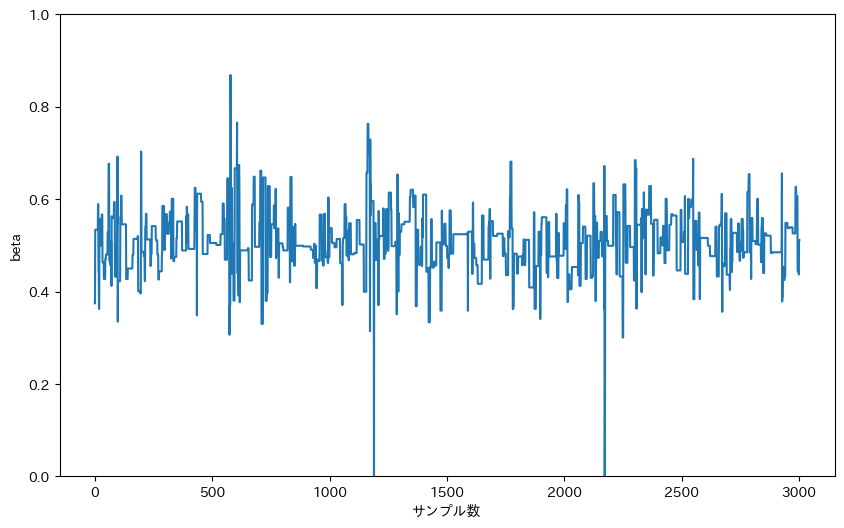

In [53]:
# サンプリング結果の可視化
plt.figure(figsize=(10, 6))
plt.plot(beta_samples)
plt.xlabel('サンプル数')
plt.ylabel('beta')
plt.ylim(0,1)
plt.show()

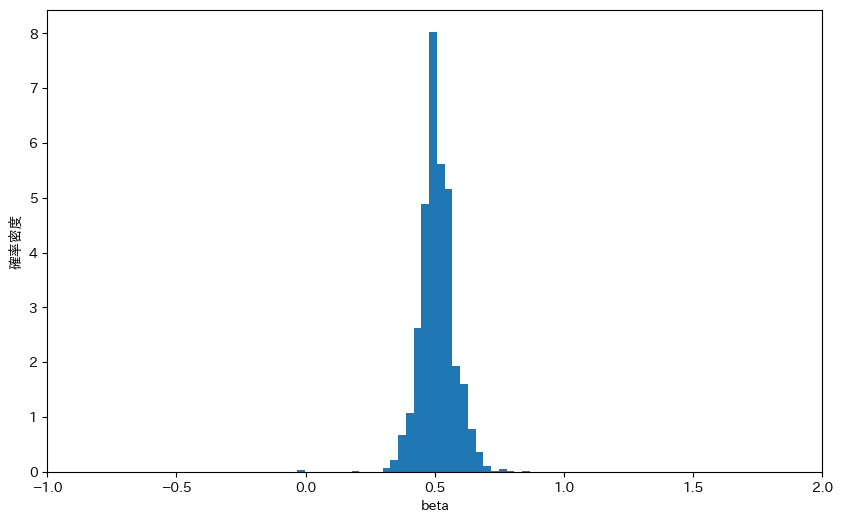

In [54]:
# サンプリング結果のヒストグラム
plt.figure(figsize=(10, 6))
plt.hist(beta_samples, bins=30, density=True)
plt.xlabel('beta')
plt.ylabel('確率密度')
plt.xlim(-1,2)
plt.show()

In [55]:
median = np.median(beta_samples)
percentile_10 = np.percentile(beta_samples, 10)
percentile_90 = np.percentile(beta_samples, 90)
print(f'中央値:{median:1f} \n90パーセンタイル:{percentile_90:1f} \n10パーセンタイル:{percentile_10:1f}')

中央値:0.504450 
90パーセンタイル:0.589342 
10パーセンタイル:0.433295


### 収束しないケース
- 初期値に大きな値を設定し、事前分布の幅も広く設定する
- この場合、理想的な値に向かうものの、収束しない
- MH法はiterごとにパラメータを更新する幅が限られるため、理想的な値までたどり着くことができなかったケース

In [56]:
# メトロポリス法の実装
np.random.seed(42) # 再現性のためのシード設定
beta_current = 50 # 初期値、敢えて大きな値を設定
num_samples = 3000 # サンプリング数
beta_samples = [beta_current] # サンプリング結果を格納するリスト
for i in range(num_samples):
    beta_proposed = proposal(beta_current) # 提案分布からパラメータをサンプリング

    # 尤度算出
    likelihood_current = likelihood(beta_current, x, y) # 現在の尤度
    likelihood_proposed = likelihood(beta_proposed, x, y) # 提案値の尤度

    # 事前分布の確率密度算出
    prior_current = prior(beta_current,mu=0,sigma=100) # 現在の事前分布の確率密度
    prior_proposed = prior(beta_proposed,mu=0,sigma=100) # 提案値の事前分布の確率密度

    # 事後分布の確率密度算出
    posterior_current = posterior(likelihood_current, prior_current) # 現在の事後分布の確率密度
    posterior_proposed = posterior(likelihood_proposed, prior_proposed) # 提案値の事後分布の確率密度

    # 採択の判定
    prob_ratio = posterior_proposed / posterior_current # 採択率は事後分布の確率密度の比とする
    if prob_ratio >= 1: # 比が1以上の場合は採択
        beta_current = beta_proposed
    elif np.random.rand() < prob_ratio: # 0~1の一様乱数が採択率より小さい場合は採択
        beta_current = beta_proposed
    else: # 比が1未満かつ乱数が採択率より大きい場合は棄却
        beta_current = beta_current

    beta_samples.append(beta_current) # サンプリング結果を格納

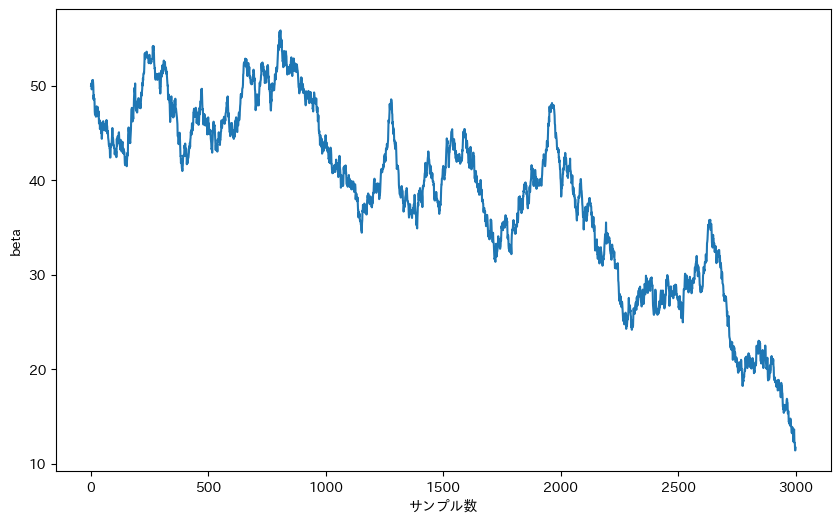

In [57]:
# サンプリング結果の可視化
plt.figure(figsize=(10, 6))
plt.plot(beta_samples)
plt.xlabel('サンプル数')
plt.ylabel('beta')
#plt.ylim(0,1)
plt.show()

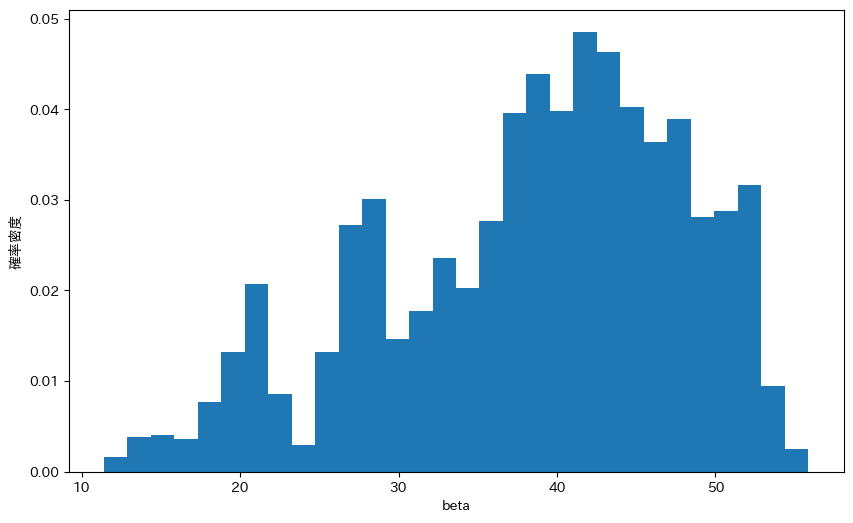

In [58]:
# サンプリング結果のヒストグラム
plt.figure(figsize=(10, 6))
plt.hist(beta_samples, bins=30, density=True)
plt.xlabel('beta')
plt.ylabel('確率密度')
#plt.xlim(-1,2)
plt.show()

In [59]:
median = np.median(beta_samples)
percentile_10 = np.percentile(beta_samples, 10)
percentile_90 = np.percentile(beta_samples, 90)
print(f'中央値:{median:1f} \n90パーセンタイル:{percentile_90:1f} \n10パーセンタイル:{percentile_10:1f}')

中央値:39.883933 
90パーセンタイル:50.205906 
10パーセンタイル:25.025970
